In [175]:
import pandas as pd
import scipy as sc
import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
import seaborn as sns
import sklearn
from sklearn import linear_model, metrics, preprocessing, model_selection
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score, f1_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from collections import Counter
from scipy.special import expit
from scipy.special import logit
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [176]:
df = pd.read_csv("raw_data.csv")
tempdf = pd.read_csv("data_firsts.csv")
df = pd.concat([df,tempdf])
df = df.copy()
df = df.drop('Unnamed: 0', axis=1) #7510 rows × 42 columns

#Drop duplicated links
df.drop_duplicates(subset='Link', keep='last', inplace=True) #4209 rows × 42 columns

# Data Handling

In [143]:
#Drop un-needed rows
df.dropna(thresh = 10, inplace = True)
df.dropna(subset = 'Name Romaji', inplace = True)
df.dropna(subset = 'Start Year', inplace = True)
df.dropna(subset = 'Status', inplace = True) 

#Fixing index col after rows delete
df = df.reset_index() 
df = df.drop('index', axis=1) 

#Filling NaN values before merging 
df['Rating 10'].fillna(0, inplace=True)
df['Rating 20'].fillna(0, inplace=True)
df['Rating 30'].fillna(0, inplace=True)
df['Rating 40'].fillna(0, inplace=True)
df['Rating 50'].fillna(0, inplace=True)
df['Rating 60'].fillna(0, inplace=True)
df['Rating 70'].fillna(0, inplace=True)
df['Rating 80'].fillna(0, inplace=True)
df['Rating 90'].fillna(0, inplace=True)
df['Rating 100'].fillna(0, inplace=True)

#Filling missing numeric values
df['Favorites'].fillna(df['Favorites'].mean(), inplace=True)
df['Rating Rank'].fillna(0, inplace=True)
df['Popularity Rank'].fillna(0, inplace=True)
df['Volume Count'].fillna(df['Volume Count'].mean(), inplace=True)
df['Popularity'].fillna(df['Popularity'].median(), inplace=True)
df['Anime Release Date'].fillna(df['Anime Release Date'].median(), inplace=True)

#Filling missing non-numeric values
df.Source = df.Source.fillna(df.Source.mode()[0])

for i in range(0, df.shape[0]):X
    if df.loc[i,'Name English'] is np.nan:
        df.loc[i,'Name English'] = df.loc[i,'Name Romaji']
    if df.loc[i,'Name Native'] is np.nan:
        df.loc[i,'Name Native'] = df.loc[i,'Name Romaji']
    if df.loc[i,'Synonyms'] is np.nan:
        df.loc[i,'Synonyms'] = df.loc[i,'Name Romaji']
    if df.loc[i,'Tag_One'] is np.nan:
        df.loc[i,'Tag_One'] = 'No Tag'
    if df.loc[i,'Tag_Two'] is np.nan:
        df.loc[i,'Tag_Two'] = 'No Tag'
    if df.loc[i,'Tag_Three'] is np.nan:
        df.loc[i,'Tag_Three'] = 'No Tag'
    if df.loc[i,'Genre_One'] is np.nan:
        df.loc[i,'Genre_One'] = 'No Genre'
    if df.loc[i,'Genre_Two'] is np.nan:
        df.loc[i,'Genre_Two'] = 'No Genre'
    if df.loc[i,'Genre_Three'] is np.nan:
        df.loc[i,'Genre_Three'] = 'No Genre'
        
    df['Average Rating'] = (((df['Rating 10'])*10 + (df['Rating 20'])*20 + (df['Rating 30'])*30 + (df['Rating 40'])*40 +
                            (df['Rating 50'])*50 + (df['Rating 60'])*60 + (df['Rating 70'])*70 + (df['Rating 80'])*80 +
                            (df['Rating 90'])*90 + (df['Rating 100'])*100)/((df['Rating 10']) + (df['Rating 20']) + 
                            (df['Rating 30']) + (df['Rating 40']) +(df['Rating 50']) + (df['Rating 60']) + (df['Rating 70'])
                            + (df['Rating 80']) +(df['Rating 90']) + (df['Rating 100']))) #Adding average
    
for i in range(0, df.shape[0]):
    if np.isnan(df.loc[i,'Average Rating']):
        df.loc[i,'Average Rating'] = df.loc[i,'Mean Score']
df['Average Rating'].fillna(df['Average Rating'].mean(), inplace=True)
#df.dropna(subset = 'Average Rating', inplace = True)

#Dropping unnecessary columns
df = df.drop(['Rating 10','Rating 20','Rating 30','Rating 40','Rating 50','Rating 60',
             'Rating 70','Rating 80','Rating 90','Rating 100'], axis=1)
df = df.drop('Chapter Count', axis=1)
df = df.drop('End Date', axis=1)
df = df.drop('Average Score', axis=1)
df = df.drop('Mean Score', axis=1)
df = df.drop('Related 1 Type', axis=1)
df = df.drop('Related 2 Type', axis=1)
df = df.drop('Popularity Number', axis=1)
df = df.drop('Rating Number', axis=1)
df = df.drop('Format', axis=1)

bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = [1,2,3,4,5,6,7,8,9,10]
df['Average_Rating_binned'] = pd.cut(df['Average Rating'], bins, labels = labels)

In [144]:
#Change type to save space
df["Name Romaji"] = df["Name Romaji"].astype('category')
df["Name Native"] = df["Name Native"].astype('category')
df["Name English"] = df["Name English"].astype('category')
df["Synonyms"] = df["Synonyms"].astype('category')
df["Status"] = df["Status"].astype('category')
df["Source"] = df["Source"].astype('category')
df["Genre_One"] = df["Genre_One"].astype('category')
df["Genre_Two"] = df["Genre_Two"].astype('category')
df["Genre_Three"] = df["Genre_Three"].astype('category')
df["Tag_One"] = df["Tag_One"].astype('category')
df["Tag_Two"] = df["Tag_Two"].astype('category')
df["Tag_Three"] = df["Tag_Three"].astype('category')
df["Start Date"] = df["Start Date"].astype('category')
df["Rating Rank"] = df["Rating Rank"].astype('category')
df["Popularity Rank"] = df["Popularity Rank"].astype('category')
df["Has Anime"] = df["Has Anime"].astype('int')

replace_map_Genre = {'Drama':1, 'Adventure':2, 'Action':3, 'Comedy':4, 'Mystery':5, 'Romance':6, 'Fantasy':7,
 'Horror':8, 'Sci-Fi':9, 'Psychological':10, 'Ecchi':11, 'Supernatural':12, 'Music':13,
 'Thriller':14, 'Slice of Life':15, 'Sports':16, 'Mahou Shoujo':17, 'Mecha':18, 'No Genre':0}

df_NUM = df.copy()
df_NUM.replace(replace_map_Genre, inplace = True)

df = pd.get_dummies(df, columns=['Status'], prefix = ['Status'])
df = pd.get_dummies(df, columns=['Source'], prefix = ['Source'])

# 4078 rows × 40 columns

# Advanced Data Analysis

In [145]:
df['Has Anime'].value_counts(normalize=True)

0    0.850417
1    0.149583
Name: Has Anime, dtype: float64

In [146]:
gen_names = ['Drama', 'Adventure', 'Action', 'Comedy', 'Mystery','Romance','Fantasy','Horror','Sci-Fi',
                'Psychological','Ecchi','Supernatural','Music','Thriller','Slice of Life','Sports','Mahou Shoujo','Mecha','No Genre']
gen_num_books = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
gen_num_anime = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

for g in df_NUM["Genre_One"]:
    gen_num_books[g]+= 1
    
for g2 in df_NUM["Genre_Two"]:
    gen_num_books[g2]+= 1
    
for g3 in df_NUM["Genre_Three"]:
    gen_num_books[g3]+= 1
    
    
for ai, a1 in df_NUM.iterrows():
    gen_num_anime[a1["Genre_One"]] += a1["Has Anime"]
    gen_num_anime[a1["Genre_Two"]] += a1["Has Anime"]
    gen_num_anime[a1["Genre_Three"]] += a1["Has Anime"]


gen_data = {"Genre Names":gen_names,
            "Number of Books":gen_num_books,
            "Number of Anime":gen_num_anime,
                                                }
gen_df = pd.DataFrame({'Number of Books':gen_num_books,
                       'Number of Anime':gen_num_anime},
                      index = gen_names)

gen_df = gen_df.drop(labels = ['No Genre'],axis = 0)
gen_df

,Number of Books,Number of Anime
Drama,2499,274
Adventure,822,170
Action,945,133
Comedy,1447,266
Mystery,1568,217
Romance,285,68
Fantasy,1273,134
Horror,1727,183
Sci-Fi,84,25
Psychological,232,83


In [147]:
df_dummies = pd.get_dummies(df[['Genre_One', 'Genre_Two', 'Genre_Three']])

In [148]:
for genere in gen_names:
    df_dummies['is'+ genere] = df_dummies['Genre_One_'+genere] if df_dummies['Genre_One_'+genere] is not None else 0 | df_dummies['Genre_Two_'+genere] if df_dummies['Genre_Two_'+genere] is not None else 0 | df_dummies['Genre_Three_'+genere] if df_dummies['Genre_Three_'+genere] is not None else 0
    try:
        df_dummies = df_dummies.drop('Genre_One_'+genere, axis=1)
    except: next
    try:
        df_dummies = df_dummies.drop('Genre_Two_'+genere, axis=1)
    except: next
    try:
        df_dummies = df_dummies.drop('Genre_Three_'+genere, axis=1)
    except: next

In [149]:
df_dummies

,isDrama,isAdventure,isAction,isComedy,isMystery,isRomance,isFantasy,isHorror,isSci-Fi,isPsychological,isEcchi,isSupernatural,isMusic,isThriller,isSlice of Life,isSports,isMahou Shoujo,isMecha,isNo Genre
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4073,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4074,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4075,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4076,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [150]:
df = pd.concat([df,df_dummies], axis = 1)
df = df.drop('Genre_One', axis=1)
df = df.drop('Genre_Two', axis=1)
df = df.drop('Genre_Three', axis=1)

# Machine Learning
   ### Logistic Regression

#### Input & Feature Extractor

In [151]:
df_matrix=df[["Start Year", "Volume Count","Status_Cancelled","Status_Finished",
             "Status_Hiatus", "Status_Not Yet Released", "Source_Anime","Source_Game","Source_Light Novel",
              "Source_Live Action", "Source_Manga", "Source_Novel",
              "Average_Rating_binned",
              #"Source_Multimedia Project",
              #"Average Rating",
              #"Status_Releasing",
              "Name Word Count",
              "Source_Original", "Source_Other", "Source_Video Game", "Source_Visual Novel", "Source_Web Novel", "isDrama",
              "isAdventure","isAction", "isComedy","isMystery","isRomance","isFantasy","isHorror", "isSci-Fi", "isPsychological",
              "isSupernatural", "isMusic", "isThriller", "isSlice of Life","isSports", "isMahou Shoujo", "isMecha", "isNo Genre",
              "Has Anime"]].copy()
df_matrix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4078 entries, 0 to 4077
Data columns (total 38 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Start Year               4078 non-null   float64 
 1   Volume Count             4078 non-null   float64 
 2   Status_Cancelled         4078 non-null   uint8   
 3   Status_Finished          4078 non-null   uint8   
 4   Status_Hiatus            4078 non-null   uint8   
 5   Status_Not Yet Released  4078 non-null   uint8   
 6   Source_Anime             4078 non-null   uint8   
 7   Source_Game              4078 non-null   uint8   
 8   Source_Light Novel       4078 non-null   uint8   
 9   Source_Live Action       4078 non-null   uint8   
 10  Source_Manga             4078 non-null   uint8   
 11  Source_Novel             4078 non-null   uint8   
 12  Average_Rating_binned    4078 non-null   category
 13  Name Word Count          4078 non-null   float64 
 14  Source_O

#### Feature Vector

In [152]:
TRAINING_FEATURES = df_matrix.columns[df_matrix.columns != 'Has Anime']
TARGET_FEATURE = 'Has Anime'
X = df_matrix[TRAINING_FEATURES]
y = df_matrix[TARGET_FEATURE]
y.head()

0    0
1    0
2    0
3    0
4    0
Name: Has Anime, dtype: int32

#### Machine Learning Algorithm

In [153]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Initial amount of samples: #{}".format(X.shape[0]))
print("Number of training samples: #{}".format(X_train.shape[0]))
print("Number of test samples: #{}".format(X_test.shape[0]))
print("\nTarget distribution in original dataset:\n{}".format(y.value_counts()))
print("\nTarget distribution in the training set:\n{}\n".format(y_train.value_counts()))
print("Target distribution in the test set:\n{}".format(y_test.value_counts()))

Initial amount of samples: #4078
Number of training samples: #3262
Number of test samples: #816

Target distribution in original dataset:
0    3468
1     610
Name: Has Anime, dtype: int64

Target distribution in the training set:
0    2784
1     478
Name: Has Anime, dtype: int64

Target distribution in the test set:
0    684
1    132
Name: Has Anime, dtype: int64


In [154]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
print("Mean: ", X_train_scaled.mean(axis=0))
print("Standard Deviation: ", X_train_scaled.std(axis=0))

Mean:  [-1.91772478e-14 -2.13467775e-16  1.63368195e-17 -4.08420487e-17
 -3.70301242e-17  1.19803343e-17 -7.18820058e-17  2.17824260e-17
  8.71297040e-18  0.00000000e+00 -3.53964422e-17 -1.08912130e-17
 -1.30694556e-17  2.15101457e-17  1.72081165e-16 -1.52476982e-17
 -4.13866094e-17  2.17824260e-18  2.17824260e-17  4.08420487e-17
 -8.71297040e-17 -9.80209170e-18 -2.39606686e-17  2.61389112e-17
 -7.62384910e-17 -1.00743720e-17 -2.94062751e-17 -1.63368195e-17
 -6.53472780e-18 -3.59410029e-17  2.17824260e-18  1.96041834e-17
 -8.71297040e-18 -1.85150621e-17 -8.71297040e-18  4.35648520e-18
 -2.61389112e-17]
Standard Deviation:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [155]:
X_test_scaled = scaler.transform(X_test)
print("Mean: ", X_test_scaled.mean(axis=0))
print("Standard Deviation: ", X_test_scaled.std(axis=0))

Mean:  [-1.96072620e-02  5.63344494e-03 -2.81600806e-02 -2.93014816e-02
 -4.71451601e-02  4.07141642e-02  2.64799140e-02 -2.47688702e-02
  7.69415520e-02  1.22549020e-03 -3.95958889e-02 -3.91810547e-02
  1.33234989e-02 -2.47909027e-02 -1.58335646e-02  2.90990779e-03
  3.48367031e-02  2.49686813e-03 -6.07643620e-02  2.75667081e-02
 -1.77295155e-04 -1.45306489e-02  3.86898646e-02 -9.96190836e-05
 -3.72960697e-02 -6.39834907e-02 -4.98491686e-02  6.37810069e-02
 -7.85541735e-03  1.14429490e-02  5.34521474e-02 -2.47688702e-02
  1.27207211e-02 -1.43266308e-02 -3.91810547e-02  1.45496697e-02
  2.71057500e-02]
Standard Deviation:  [1.01261354e+00 9.30511366e-01 7.56395559e-01 1.00723404e+00
 6.33431264e-01 1.26277263e+00 1.08067157e+00 0.00000000e+00
 1.45632296e+00 3.49855452e-02 8.76721403e-01 6.93889390e-18
 9.39915801e-01 9.41533777e-01 1.02017915e+00 1.01372070e+00
 1.12856353e+00 1.01012013e+00 0.00000000e+00 1.04044412e+00
 9.99719222e-01 9.95521806e-01 1.02318616e+00 9.99701676e-01
 9.

In [156]:
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled_in_range = min_max_scaler.fit_transform(X_train)
print("Min Value: ", X_train_scaled_in_range.min(axis=0))
print("Max Value: ", X_train_scaled_in_range.max(axis=0))
X_test_scaled_in_range = min_max_scaler.transform(X_test)

Min Value:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Max Value:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [157]:
clf_model = LogisticRegression().fit(X_train, y_train)
y_pred=clf_model.predict(X_test)

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Model

In [158]:
resDF=pd.DataFrame({"Actual":y_test,"Predicted":y_pred})
resDF["correct"]=abs((resDF["Actual"]^resDF["Predicted"])-1)
resDF[resDF["correct"]==1]
resDF

,Actual,Predicted,correct
33,1,0,0
3232,0,0,1
1556,1,0,0
3402,0,0,1
457,1,1,1
...,...,...,...
67,0,0,1
1688,0,0,1
932,0,0,1
221,0,0,1


In [159]:
resDF['Actual'].value_counts()

0    684
1    132
Name: Actual, dtype: int64

In [160]:
resDF['Predicted'].value_counts()

0    751
1     65
Name: Predicted, dtype: int64

In [161]:
resDF['correct'].value_counts()

1    697
0    119
Name: correct, dtype: int64

In [162]:
y_pred = resDF['Predicted']
y_actual = resDF['Actual']
matrix = metrics.confusion_matrix(y_actual, y_pred)

In [163]:
confusionDF = pd.DataFrame(matrix)
confusionDF.index = ["Actual False" , "Actual True"]
confusionDF.columns = ["Predicted False" , "Predicted True"]
confusionDF

,Predicted False,Predicted True
Actual False,658,26
Actual True,93,39


#### Evaluation

In [164]:
print("accuracy is:",metrics.accuracy_score(y_actual, y_pred))  
print("precision is:",metrics.precision_score(y_actual, y_pred))
print("recall is:",metrics.recall_score(y_actual, y_pred))
print("f1 is:",metrics.f1_score(y_actual, y_pred))
print("r2 is:",metrics.r2_score(y_actual, y_pred))

accuracy is: 0.8541666666666666
precision is: 0.6
recall is: 0.29545454545454547
f1 is: 0.3959390862944162
r2 is: -0.07549175970228594


#### Correlation test to get a better result

C:\Users\Mor\AppData\Local\Temp\ipykernel_21144\1614715046.py:17: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  df_matrix.corr().style.background_gradient(cmap, axis=1)\


,Start Year,Volume Count,Status_Cancelled,Status_Finished,Status_Hiatus,Status_Not Yet Released,Source_Anime,Source_Game,Source_Light Novel,Source_Live Action,Source_Manga,Source_Novel,Name Word Count,Source_Original,Source_Other,Source_Video Game,Source_Visual Novel,Source_Web Novel,isDrama,isAdventure,isAction,isComedy,isMystery,isRomance,isFantasy,isHorror,isSci-Fi,isPsychological,isSupernatural,isMusic,isThriller,isSlice of Life,isSports,isMahou Shoujo,isMecha,isNo Genre,Has Anime
Start Year,1.00,-0.18,0.00,-0.46,-0.03,0.10,-0.14,-0.01,-0.00,-0.04,-0.06,0.02,0.41,0.14,0.03,-0.06,-0.08,0.05,-0.09,0.06,-0.06,0.07,-0.08,0.05,0.08,-0.06,-0.05,-0.00,-0.01,0.00,-0.03,0.02,0.00,-0.01,-0.14,0.00,-0.33
Volume Count,-0.18,1.00,0.02,-0.01,-0.00,-0.00,-0.06,0.01,-0.02,-0.01,-0.08,-0.02,-0.07,0.14,-0.05,-0.06,-0.04,-0.00,-0.09,0.03,0.08,0.04,-0.05,-0.09,-0.01,-0.01,-0.01,-0.02,-0.02,-0.04,0.00,-0.03,0.01,-0.01,-0.00,0.01,0.29
Status_Cancelled,0.00,0.02,1.00,-0.08,-0.00,-0.00,-0.01,-0.00,-0.00,-0.00,-0.01,-0.00,-0.01,0.02,-0.01,-0.01,-0.01,-0.00,-0.00,0.03,0.01,0.00,-0.01,-0.01,-0.01,-0.00,-0.00,-0.00,-0.01,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.01,-0.00
Status_Finished,-0.46,-0.01,-0.08,1.00,-0.09,-0.09,0.12,0.02,0.04,0.01,0.11,0.03,-0.34,-0.19,0.02,0.07,0.08,-0.06,0.10,-0.12,-0.03,-0.01,0.09,0.08,-0.07,0.04,0.04,0.02,0.02,0.03,0.02,0.02,-0.00,0.03,0.04,-0.03,0.14
Status_Hiatus,-0.03,-0.00,-0.00,-0.09,1.00,-0.01,-0.01,-0.00,-0.01,-0.00,-0.01,-0.00,-0.03,0.00,-0.01,-0.01,0.02,-0.00,-0.01,-0.02,0.02,-0.01,0.01,-0.02,0.02,0.04,-0.01,0.08,-0.01,-0.01,-0.00,-0.01,-0.00,-0.00,-0.00,-0.01,0.06
Status_Not Yet Released,0.10,-0.00,-0.00,-0.09,-0.01,1.00,-0.01,-0.00,-0.01,-0.00,-0.01,-0.00,0.01,0.02,-0.01,-0.01,-0.01,-0.00,-0.01,0.02,-0.02,-0.02,0.01,0.09,-0.00,-0.01,-0.01,-0.00,-0.01,-0.00,-0.00,0.04,-0.00,-0.00,-0.00,-0.01,-0.03
Source_Anime,-0.14,-0.06,-0.01,0.12,-0.01,-0.01,1.00,-0.00,-0.01,-0.00,-0.03,-0.01,-0.08,-0.46,-0.02,-0.02,-0.02,-0.01,0.02,-0.02,0.07,-0.05,-0.01,-0.03,-0.05,-0.01,0.03,-0.01,-0.01,-0.01,-0.00,0.03,-0.01,0.13,0.04,0.01,0.35
Source_Game,-0.01,0.01,-0.00,0.02,-0.00,-0.00,-0.00,1.00,-0.00,-0.00,-0.00,-0.00,-0.02,-0.06,-0.00,-0.00,-0.00,-0.00,-0.01,-0.01,0.03,-0.01,-0.00,-0.00,-0.01,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.05
Source_Light Novel,-0.00,-0.02,-0.00,0.04,-0.01,-0.01,-0.01,-0.00,1.00,-0.00,-0.01,-0.00,-0.01,-0.22,-0.01,-0.01,-0.01,-0.00,0.00,-0.01,-0.00,-0.00,-0.01,0.03,-0.01,0.04,-0.01,-0.00,-0.01,-0.01,-0.00,-0.01,-0.00,-0.00,-0.00,0.02,0.01
Source_Live Action,-0.04,-0.01,-0.00,0.01,-0.00,-0.00,-0.00,-0.00,-0.00,1.00,-0.00,-0.00,-0.02,-0.05,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.01,-0.01,-0.00,-0.00,-0.01,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.24,-0.00,0.04


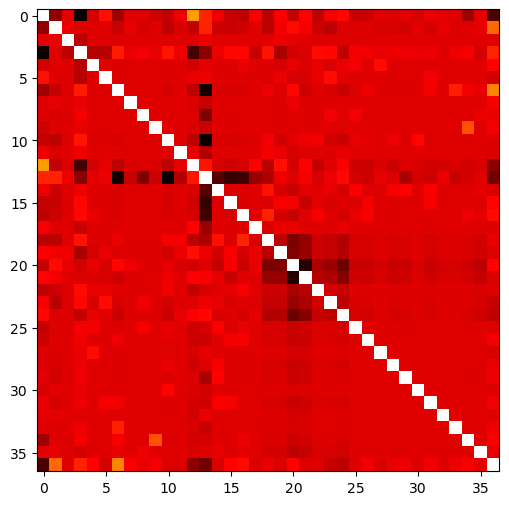

In [165]:
plt.imshow(df_matrix.corr(),cmap='hot',interpolation='nearest')

cmap=sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

df_matrix.corr().style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Correlation between features")\
    .set_precision(2)\
    .set_table_styles(magnify())

In [166]:
df_cor = df_matrix.corr()

In [167]:
for row in range(36):
    for col in range(36):
        if (df_cor.iloc[row,col] > abs(0.3) and df_cor.iloc[row,col] != 1 ):
            print(df_cor.index[row] ," : ",df_cor.columns[col] , " : ",df_cor.iloc[row,col])

Start Year  :  Name Word Count  :  0.40706413031730065
Name Word Count  :  Start Year  :  0.40706413031730065


### Random Forest

#### Input & Feature Extractor

In [168]:
df_matrix_FOREST=df[["Start Year", "Volume Count","Status_Cancelled","Status_Finished",
             "Status_Hiatus", "Status_Not Yet Released", "Source_Anime","Source_Game","Source_Light Novel",
              "Source_Live Action", "Source_Manga", "Source_Novel",
              #"Average_Rating_binned",
              #"Source_Multimedia Project",
              "Average Rating",
              "Name Word Count","Status_Releasing",
              "Source_Original", "Source_Other", "Source_Video Game", "Source_Visual Novel", "Source_Web Novel", "isDrama",
              "isAdventure","isAction", "isComedy","isMystery","isRomance","isFantasy","isHorror", "isSci-Fi", "isPsychological",
              "isSupernatural", "isMusic", "isThriller", "isSlice of Life","isSports", "isMahou Shoujo", "isMecha", "isNo Genre",
              "Has Anime"]].copy()

#### Feature Vector

In [169]:
TRAINING_FEATURES_FOREST = df_matrix_FOREST.columns[df_matrix_FOREST.columns != 'Has Anime']
TARGET_FEATURE_FOREST = 'Has Anime'
X_F = df_matrix_FOREST[TRAINING_FEATURES_FOREST]
y_F = df_matrix_FOREST[TARGET_FEATURE_FOREST]
y_F.head()

0    0
1    0
2    0
3    0
4    0
Name: Has Anime, dtype: int32

#### Machine Learning Algorithm

In [170]:
X_train_F, X_test_F, y_train_F, y_test_F = train_test_split(X_F, y_F, test_size=0.2, random_state=42)
print("Initial amount of samples: #{}".format(X_F.shape[0]))
print("Number of training samples: #{}".format(X_train_F.shape[0]))
print("Number of test samples: #{}".format(X_test_F.shape[0]))
print("\nTarget distribution in original dataset:\n{}".format(y_F.value_counts()))
print("\nTarget distribution in the training set:\n{}\n".format(y_train_F.value_counts()))
print("Target distribution in the test set:\n{}".format(y_test_F.value_counts()))

Initial amount of samples: #4078
Number of training samples: #3262
Number of test samples: #816

Target distribution in original dataset:
0    3468
1     610
Name: Has Anime, dtype: int64

Target distribution in the training set:
0    2784
1     478
Name: Has Anime, dtype: int64

Target distribution in the test set:
0    684
1    132
Name: Has Anime, dtype: int64


#### Looking for the number of estimators that will give us the best result

<AxesSubplot:xlabel='Number of Estimates', ylabel='Accuracy Score'>

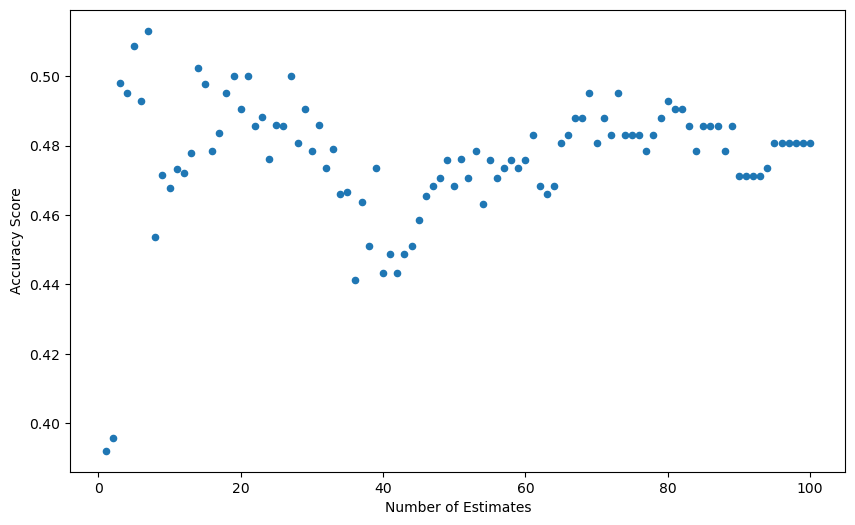

In [171]:
rf_est = []
rf_res = []
f1_max = 0
for i in range(1,101):
    rf = RandomForestClassifier(n_estimators=i, random_state=42)
    rf.fit(X_train_F, y_train_F)
    y_pred_F = rf.predict(X_test_F)
    rf_est.append(i)
    rf_res.append(f1_score(y_test_F, y_pred_F))
    rfdef = pd.DataFrame({"Number of Estimates":rf_est,"Accuracy Score":rf_res})
    if((f1_score(y_test_F, y_pred_F)) > f1_max):
        f1_max = (f1_score(y_test_F, y_pred_F))
        f1_index = i
    
rf = RandomForestClassifier(n_estimators=f1_index, random_state=42)
rf.fit(X_train_F, y_train_F)

rfdef.plot.scatter("Number of Estimates","Accuracy Score")

#### Evaluation

In [172]:
print('Accuracy is:', accuracy_score(y_test_F, y_pred_F))
print('f1 is:', f1_max) #0.5086206896551724

Accuracy is: 0.8676470588235294
f1 is: 0.5130434782608696
